# Alfred the Mail Sorting Butler: A LangGraph Example

In this notebook, **we're going to build a complete email processing workflow using LangGraph**.

This notebook is part of the <a href="https://www.hf.co/learn/agents-course">Hugging Face Agents Course</a>, a free course from beginner to expert, where you learn to build Agents.

![Agents course share](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/communication/share.png)

## What You'll Learn

In this notebook, you'll learn how to:
1. Set up a LangGraph workflow
2. Define state and nodes for email processing
3. Create conditional branching in a graph
4. Connect an LLM for classification and content generation
5. Visualize the workflow graph
6. Execute the workflow with example data

In [ ]:
# Install the required packages
%pip install -q langgraph langchain_openai langchain_huggingface

## Setting Up Our Environment

First, let's import all the necessary libraries. LangGraph provides the graph structure, while LangChain offers convenient interfaces for working with LLMs.

In [1]:
import os
from dotenv import load_dotenv
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, END, START
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

load_dotenv()

# Set your OpenAI API key here
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# Initialize our LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

## Step 1: Define Our State

In LangGraph, **State** is the central concept. It represents all the information that flows through our workflow.

For Alfred's email processing system, we need to track:
- The email being processed
- Whether it's spam or not
- The draft response (for legitimate emails)
- Conversation history with the LLM

In [2]:
class EmailState(TypedDict):
    # The email being processed
    email: Dict[str, Any]  # Contains subject, sender, body, etc.

    # Category of the email (inquiry, complaint, etc.)
    email_category: Optional[str]

    # Reason why the email was marked as spam
    spam_reason: Optional[str]

    # Analysis and decisions
    is_spam: Optional[bool]
    
    # Response generation
    email_draft: Optional[str]
    
    # Processing metadata
    messages: List[Dict[str, Any]]  # Track conversation with LLM for analysis

## Step 2: Define Our Nodes

In [15]:
def read_email(state: EmailState):
    """Alfred reads and logs the incoming email"""
    email = state["email"]
    
    # Here we might do some initial preprocessing
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    
    # No state changes needed here
    return {}


def classify_email(state: EmailState):
    """Alfred uses an LLM to determine if the email is spam or legitimate"""
    email = state["email"]

    prompt = f"""
    As Alfred the butler of Mr Wayne and his secret identity Batman, analyze this email and determine if it is spam or legitimate.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    First, determine if this email is spam.
    Answer with SPAM if it's spam, or HAM if it's legitimate.
    
    If it is SPAM, also provide a brief reason in the format: 
    REASON: <your reason here>
    
    Example:
    
    SPAM
    REASON: The email contains suspicious links.
    
    Otherwise, just return HAM.
    
    Answer:
    """

    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    # Simple logic to parse the response (in a real app, you'd want more robust parsing)
    response_text = response.content.lower()
    print(response_text)
    is_spam = "spam" in response_text and "ham" not in response_text

    # Extract a reason if it's spam
    spam_reason = None
    if is_spam and "reason:" in response_text:
        spam_reason = response_text.split("reason:")[1].strip()
    
    # Determine category if legitimate
    email_category = None
    if not is_spam:
        categories = ["inquiry", "complaint", "thank you", "request", "information"]
        for category in categories:
            if category in response_text:
                email_category = category
                break
    
    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
        "messages": new_messages
    }


def handle_spam(state: EmailState):
    """Alfred discards spam email with a note"""
    print(f"Alfred has marked the email as spam. Reason: {state['spam_reason']}")
    print("The email has been moved to the spam folder.")
    
    # We're done processing this email
    return {}


def draft_response(state: EmailState):
    """Alfred drafts a preliminary response for legitimate emails"""
    email = state["email"]
    category = state["email_category"] or "general"
    
    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, draft a polite preliminary response to this email.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    This email has been categorized as: {category}
    
    Draft a brief, professional response that Mr. Wayne can review and personalize before sending.
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # Return state updates
    return {
        "email_draft": response.content,
        "messages": new_messages
    }


def notify_mr_wayne(state: EmailState):
    email = state["email"]

    print("\n" + "=" * 50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print("\nI've prepared a draft response for your review:")
    print("-" * 50)
    print(state["email_draft"])
    print("=" * 50 + "\n")

    return {}


# Define routing logic
def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"


# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email)  # the read_email node executes the read_mail function
email_graph.add_node("classify_email", classify_email)  # the classify_email node will execute the classify_email function
email_graph.add_node("handle_spam", handle_spam)  #same logic
email_graph.add_node("drafting_response", draft_response)  #same logic
email_graph.add_node("notify_mr_wayne", notify_mr_wayne)  # same logic


## Step 3: Define Our Routing Logic

In [16]:
# Add edges
email_graph.add_edge(START, "read_email")  # After starting we go to the "read_email" node

email_graph.add_edge("read_email", "classify_email")  # after_reading we classify

# Add conditional edges
email_graph.add_conditional_edges(
    "classify_email",  # after classify, we run the "route_email" function"
    route_email,
    {
        "spam": "handle_spam",  # if it return "Spam", we go the "handle_span" node
        "legitimate": "drafting_response"  # and if it's legitimate, we go to the "drafting response" node
    }
)

# Add final edges
email_graph.add_edge("handle_spam", END)  # after handling spam we always end
email_graph.add_edge("drafting_response", "notify_mr_wayne")
email_graph.add_edge("notify_mr_wayne", END)  # after notifyinf Me wayne, we can end  too


## Step 4: Create the StateGraph and Define Edges

In [17]:
# Compile the graph
compiled_graph = email_graph.compile()

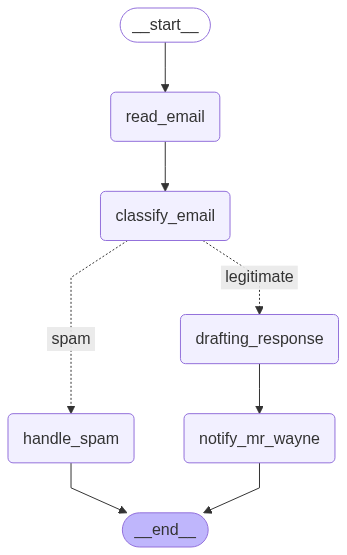

In [18]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [19]:
 # Example emails for testing
legitimate_email = {
    "sender": "Joker",
    "subject": "Found you Batman ! ",
    "body": "Mr. Wayne,I found your secret identity ! I know you're batman ! Ther's no denying it, I have proof of that and I'm coming to find you soon. I'll get my revenge. JOKER"
}

spam_email = {
    "sender": "Crypto bro",
    "subject": "The best investment of 2025",
    "body": "Mr Wayne, I just launched an ALT coin and want you to buy some !"
}
# Process legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

# Process spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from Joker with subject: Found you Batman ! 
ham

the email appears to be a direct threat from a known adversary, the joker, rather than a typical spam message. it does not contain typical spam characteristics such as unsolicited commercial content, phishing attempts, or suspicious links. instead, it is a personal threat related to mr. wayne's secret identity as batman.

Sir, you've received an email from Joker.
Subject: Found you Batman ! 

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Found you Batman!

Dear Joker,

Thank you for reaching out. Your message has been received and noted. Mr. Wayne is currently unavailable, but rest assured, your concerns will be addressed in due course.

Best regards,

Alfred Pennyworth  
Wayne Manor


Processing spam email...
Alfred is processing an email from Crypto bro with subject: The best investment of 2025
spam  
reason:

## Step 5: Inspecting Our Mail Sorting Agent with LangSmith 📡

As Alfred fine-tunes the Mail Sorting Agent, he's growing weary of debugging its runs. Agents, by nature, are unpredictable and difficult to inspect. But since he aims to build the ultimate Spam Detection Agent and deploy it in production, he needs robust traceability for future monitoring and analysis.

To do this, Alfred can use an observability tool such as [LangSmith](https://smith.langchain.com/) to trace and monitor the inner steps of the agent.

First, we need to install the necessary dependencies:

In [ ]:
%pip install -q langsmith

Next, set the LangSmith API key and project environment variables. You can get your LangSmith credentials by signing up for [LangSmith](https://smith.langchain.com).

Make sure you have:
- LANGCHAIN_API_KEY
- LANGCHAIN_TRACING_V2 = 'true' (enables LangSmith tracing)

In [20]:
import os
from dotenv import load_dotenv

load_dotenv()

# Set your LangSmith API key here
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

# Enable tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"

Now, configure the LangSmith `CallbackHandler` to capture traces.

LangSmith integrates deeply with LangChain and LangGraph via the `LangChainTracer`.

In [24]:
from langchain.callbacks.tracers import LangChainTracer

# Initialize LangSmith CallbackHandler
langsmith_handler = LangChainTracer()

We then add `config={"callbacks": [langsmith_handler]}` to the invocation of the agents and run them again.

In [25]:
# Process legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke(
    input={
        "email": legitimate_email,
        "is_spam": None,
        "spam_reason": None,
        "email_category": None,
        "email_draft": None,
        "messages": []
    },
    config={"callbacks": [langsmith_handler]}
)

# Process spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke(
    input={
        "email": spam_email,
        "is_spam": None,
        "spam_reason": None,
        "email_category": None,
        "email_draft": None,
        "messages": []
    },
    config={"callbacks": [langsmith_handler]}
)


Processing legitimate email...
Alfred is processing an email from Joker with subject: Found you Batman ! 
ham

Sir, you've received an email from Joker.
Subject: Found you Batman ! 

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Found you Batman!

Dear Joker,

Thank you for reaching out. Your message has been received and noted. Mr. Wayne is currently unavailable, but rest assured, your concerns will be addressed in due course.

Best regards,

Alfred Pennyworth  
Wayne Manor


Processing spam email...
Alfred is processing an email from Crypto bro with subject: The best investment of 2025
spam  
reason: the email is unsolicited and promotes a cryptocurrency investment, which is a common characteristic of spam emails.
Alfred has marked the email as spam. Reason: the email is unsolicited and promotes a cryptocurrency investment, which is a common characteristic of spam emails.
The email has been moved to the spam folder.


Alfred is now connected 🔌! The runs from LangGraph are being logged in LangSmith, giving him full visibility into the agent's behavior. With this setup, he's ready to revisit previous runs and refine his Mail Sorting Agent even further.

![Example trace in LangSmith](../../../figures/langsmith-alfred.png)